In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime
import seaborn as sns
from pylab import rcParams
from keras.layers import Dropout
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
from tensorflow import keras
eval_list = []

In [5]:
needfile = '/emogen/all'
def call_filelist(needfile):
    path = os.getcwd()
    files = os.listdir(path + needfile)
    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints')
    return files

# 데이터 프레임 불러오기
def call_file(files, num, needfile):
    path = os.getcwd()
    df = pd.read_csv(path + needfile+ '/' + files[num], index_col = 0)
    df.set_index('Current Time',inplace = True)
    return df



In [6]:
files = call_filelist(needfile)
df = call_file(files, 0, needfile)


X = df.iloc[:, :-7].values
y = df.iloc[:, -7:].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


history_loss = []
history_accuracy = []
history_val_loss = []
history_val_accuracy = []
print(X_train.shape)


(4628, 8)


In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)

(4628, 8, 1)


In [10]:
"""
model = Sequential()
model.add(Convolution1D(128, 3, activation='relu', input_shape = (X_train.shape[0], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(64, activation='softmax'))
model.add(LSTM(64, input_shape = (X_train.shape[0], X_train.shape[2]), recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
"""
from keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.0001)

model = Sequential()
"""model.add(Convolution1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))"""
model.add(LSTM(64,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(y_train.shape[1], activation='softmax'))

In [11]:
model.compile(loss=categorical_crossentropy , optimizer=opt, metrics=['accuracy'])

In [12]:
for num in range(len(files)):
    df = call_file(files, num, needfile)
    print(files[num])
    # 입력 데이터와 라벨 데이터를 분리
    X = df.iloc[:, :-7].values
    y = df.iloc[:, -7:].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
    # 입력 데이터를 3D 텐서로 변환
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


    print(X_train.shape)
    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights = True)
    # 모델 학습 및 체크포인트 저장
    fit_history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_val, y_val), callbacks=[earlystop])
    history_loss.extend(fit_history.history['loss'])
    history_accuracy.extend(fit_history.history['accuracy'])
    history_val_loss.extend(fit_history.history['val_loss'])
    history_val_accuracy.extend(fit_history.history['val_accuracy'])

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test)
    eval_list.append(accuracy)
    print('Test accuracy:', accuracy)
    print(num)
    #모델 저장
    model.save("my_model.h5")
    reconstructed_model = keras.models.load_model("my_model.h5")
    np.testing.assert_allclose(model.predict(X_test), 
                               reconstructed_model.predict(X_test)
                              )
    model = reconstructed_model
    model.compile(loss=categorical_crossentropy , optimizer='rmsprop', metrics=['accuracy'])


User002M_new_emo_gender.csv
(4165, 8, 1)
Epoch 1/100
1389/1389 [==============================] - 7s 4ms/step - loss: 1.7362 - accuracy: 0.8447 - val_loss: 1.5245 - val_accuracy: 0.8810
Epoch 2/100
1389/1389 [==============================] - 5s 4ms/step - loss: 1.3031 - accuracy: 0.8776 - val_loss: 1.0762 - val_accuracy: 0.8810
Epoch 3/100
1389/1389 [==============================] - 5s 3ms/step - loss: 0.8771 - accuracy: 0.8776 - val_loss: 0.6970 - val_accuracy: 0.8810
Epoch 4/100
1389/1389 [==============================] - 5s 3ms/step - loss: 0.6093 - accuracy: 0.8776 - val_loss: 0.5413 - val_accuracy: 0.8810
Epoch 5/100
1389/1389 [==============================] - 5s 4ms/step - loss: 0.5286 - accuracy: 0.8776 - val_loss: 0.5043 - val_accuracy: 0.8810
Epoch 6/100
1389/1389 [==============================] - 5s 3ms/step - loss: 0.5056 - accuracy: 0.8776 - val_loss: 0.4881 - val_accuracy: 0.8810
Epoch 7/100
1389/1389 [==============================] - 5s 3ms/step - loss: 0.4910 - acc

Epoch 12/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2506 - accuracy: 0.9465 - val_loss: 0.2874 - val_accuracy: 0.9360
Epoch 13/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2476 - accuracy: 0.9465 - val_loss: 0.2906 - val_accuracy: 0.9360
Epoch 14/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2489 - accuracy: 0.9465 - val_loss: 0.2937 - val_accuracy: 0.9360
Epoch 15/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2504 - accuracy: 0.9465 - val_loss: 0.2922 - val_accuracy: 0.9360
Epoch 16/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2505 - accuracy: 0.9465 - val_loss: 0.2921 - val_accuracy: 0.9360
Epoch 17/100
1270/1270 [==============================] - 4s 3ms/step - loss: 0.2501 - accuracy: 0.9465 - val_loss: 0.2943 - val_accuracy: 0.9360
Epoch 17: early stopping
17/17 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9547
Test accurac

2008/2008 [==============================] - 8s 4ms/step - loss: 0.8423 - accuracy: 0.7591 - val_loss: 0.9006 - val_accuracy: 0.7390
Epoch 11/100
2008/2008 [==============================] - 7s 4ms/step - loss: 0.8462 - accuracy: 0.7591 - val_loss: 0.9000 - val_accuracy: 0.7390
Epoch 11: early stopping
27/27 [==============================] - 0s 2ms/step - loss: 0.8900 - accuracy: 0.7455
Test accuracy: 0.7455196976661682
6
27/27 [==============================] - 0s 2ms/step
User009M_new_emo_gender.csv
(4274, 8, 1)
Epoch 1/100
1425/1425 [==============================] - 7s 4ms/step - loss: 0.8614 - accuracy: 0.8678 - val_loss: 0.7472 - val_accuracy: 0.8756
Epoch 2/100
1425/1425 [==============================] - 5s 4ms/step - loss: 0.7664 - accuracy: 0.8678 - val_loss: 0.7096 - val_accuracy: 0.8756
Epoch 3/100
1425/1425 [==============================] - 5s 4ms/step - loss: 0.7288 - accuracy: 0.8678 - val_loss: 0.6787 - val_accuracy: 0.8756
Epoch 4/100
1425/1425 [=====================

1535/1535 [==============================] - 6s 4ms/step - loss: 0.4849 - accuracy: 0.8755 - val_loss: 0.4585 - val_accuracy: 0.8828
Epoch 7: early stopping
20/20 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.8844
Test accuracy: 0.8843749761581421
10
20/20 [==============================] - 0s 2ms/step
User015F_new_emo_gender.csv
(5083, 8, 1)
Epoch 1/100
1695/1695 [==============================] - 8s 4ms/step - loss: 1.3800 - accuracy: 0.6968 - val_loss: 1.1872 - val_accuracy: 0.7317
Epoch 2/100
1695/1695 [==============================] - 6s 4ms/step - loss: 1.2361 - accuracy: 0.6968 - val_loss: 1.0854 - val_accuracy: 0.7317
Epoch 3/100
1695/1695 [==============================] - 6s 4ms/step - loss: 1.1274 - accuracy: 0.6968 - val_loss: 0.9995 - val_accuracy: 0.7317
Epoch 4/100
1695/1695 [==============================] - 6s 4ms/step - loss: 1.0485 - accuracy: 0.6968 - val_loss: 0.9610 - val_accuracy: 0.7317
Epoch 5/100
1695/1695 [======================

1836/1836 [==============================] - 6s 3ms/step - loss: 0.4091 - accuracy: 0.9141 - val_loss: 0.4228 - val_accuracy: 0.9129
Epoch 4/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4063 - accuracy: 0.9141 - val_loss: 0.4235 - val_accuracy: 0.9129
Epoch 5/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4059 - accuracy: 0.9141 - val_loss: 0.4224 - val_accuracy: 0.9129
Epoch 6/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4074 - accuracy: 0.9141 - val_loss: 0.4232 - val_accuracy: 0.9129
Epoch 7/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4049 - accuracy: 0.9141 - val_loss: 0.4226 - val_accuracy: 0.9129
Epoch 8/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4062 - accuracy: 0.9141 - val_loss: 0.4222 - val_accuracy: 0.9129
Epoch 9/100
1836/1836 [==============================] - 6s 3ms/step - loss: 0.4090 - accuracy: 0.9141 - val_loss: 0.4211 - val_accuracy: 0.91

2052/2052 [==============================] - 7s 3ms/step - loss: 0.7737 - accuracy: 0.7921 - val_loss: 0.7350 - val_accuracy: 0.7947
Epoch 11/100
2052/2052 [==============================] - 7s 3ms/step - loss: 0.7758 - accuracy: 0.7921 - val_loss: 0.7329 - val_accuracy: 0.7947
Epoch 12/100
2052/2052 [==============================] - 7s 3ms/step - loss: 0.7754 - accuracy: 0.7921 - val_loss: 0.7337 - val_accuracy: 0.7947
Epoch 13/100
2052/2052 [==============================] - 6s 3ms/step - loss: 0.7746 - accuracy: 0.7921 - val_loss: 0.7326 - val_accuracy: 0.7947
Epoch 13: early stopping
27/27 [==============================] - 0s 2ms/step - loss: 0.7304 - accuracy: 0.7965
Test accuracy: 0.7964912056922913
17
27/27 [==============================] - 0s 2ms/step
User032M_new_emo_gender.csv
(5971, 8, 1)
Epoch 1/100
1991/1991 [==============================] - 10s 4ms/step - loss: 0.7369 - accuracy: 0.7974 - val_loss: 0.7446 - val_accuracy: 0.7977
Epoch 2/100
1991/1991 [=================

1769/1769 [==============================] - 6s 4ms/step - loss: 0.7157 - accuracy: 0.7741 - val_loss: 0.7460 - val_accuracy: 0.7702
Epoch 4/100
1769/1769 [==============================] - 6s 3ms/step - loss: 0.7118 - accuracy: 0.7741 - val_loss: 0.7387 - val_accuracy: 0.7702
Epoch 5/100
1769/1769 [==============================] - 6s 4ms/step - loss: 0.7075 - accuracy: 0.7741 - val_loss: 0.7307 - val_accuracy: 0.7702
Epoch 6/100
1769/1769 [==============================] - 6s 4ms/step - loss: 0.6993 - accuracy: 0.7741 - val_loss: 0.7256 - val_accuracy: 0.7702
Epoch 7/100
1769/1769 [==============================] - 6s 4ms/step - loss: 0.6911 - accuracy: 0.7741 - val_loss: 0.7222 - val_accuracy: 0.7702
Epoch 8/100
1769/1769 [==============================] - 7s 4ms/step - loss: 0.6886 - accuracy: 0.7741 - val_loss: 0.7175 - val_accuracy: 0.7702
Epoch 9/100
1769/1769 [==============================] - 7s 4ms/step - loss: 0.6897 - accuracy: 0.7741 - val_loss: 0.7146 - val_accuracy: 0.77

2280/2280 [==============================] - 9s 4ms/step - loss: 1.1535 - accuracy: 0.6701 - val_loss: 1.0557 - val_accuracy: 0.6789
Epoch 3/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.1081 - accuracy: 0.6702 - val_loss: 1.0293 - val_accuracy: 0.6789
Epoch 4/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.0942 - accuracy: 0.6702 - val_loss: 1.0179 - val_accuracy: 0.6789
Epoch 5/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.0814 - accuracy: 0.6702 - val_loss: 1.0089 - val_accuracy: 0.6789
Epoch 6/100
2280/2280 [==============================] - 10s 4ms/step - loss: 1.0740 - accuracy: 0.6702 - val_loss: 1.0118 - val_accuracy: 0.6789
Epoch 7/100
2280/2280 [==============================] - 9s 4ms/step - loss: 1.0762 - accuracy: 0.6702 - val_loss: 1.0061 - val_accuracy: 0.6789
Epoch 8/100
2280/2280 [==============================] - 10s 4ms/step - loss: 1.0716 - accuracy: 0.6702 - val_loss: 1.0041 - val_accuracy: 0.

Epoch 7: early stopping
30/30 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.7233
Test accuracy: 0.7233368754386902
28
30/30 [==============================] - 0s 2ms/step
User047F_new_emo_gender.csv
(6296, 8, 1)
Epoch 1/100
2099/2099 [==============================] - 10s 4ms/step - loss: 1.2549 - accuracy: 0.6804 - val_loss: 1.2262 - val_accuracy: 0.6825
Epoch 2/100
2099/2099 [==============================] - 8s 4ms/step - loss: 1.1627 - accuracy: 0.6804 - val_loss: 1.1490 - val_accuracy: 0.6825
Epoch 3/100
2099/2099 [==============================] - 8s 4ms/step - loss: 1.1161 - accuracy: 0.6803 - val_loss: 1.0997 - val_accuracy: 0.6825
Epoch 4/100
2099/2099 [==============================] - 8s 4ms/step - loss: 1.0808 - accuracy: 0.6804 - val_loss: 1.0647 - val_accuracy: 0.6825
Epoch 5/100
2099/2099 [==============================] - 8s 4ms/step - loss: 1.0660 - accuracy: 0.6804 - val_loss: 1.0411 - val_accuracy: 0.6825
Epoch 6/100
2099/2099 [=========

1873/1873 [==============================] - 8s 4ms/step - loss: 0.6450 - accuracy: 0.8208 - val_loss: 0.6214 - val_accuracy: 0.8249
Epoch 5/100
1873/1873 [==============================] - 8s 4ms/step - loss: 0.6420 - accuracy: 0.8208 - val_loss: 0.6214 - val_accuracy: 0.8249
Epoch 6/100
1873/1873 [==============================] - 8s 4ms/step - loss: 0.6442 - accuracy: 0.8208 - val_loss: 0.6230 - val_accuracy: 0.8249
Epoch 6: early stopping
25/25 [==============================] - 0s 2ms/step - loss: 0.6032 - accuracy: 0.8233
Test accuracy: 0.8233034610748291
32
25/25 [==============================] - 0s 2ms/step
User051M_new_emo_gender.csv
(5075, 8, 1)
Epoch 1/100
1692/1692 [==============================] - 9s 4ms/step - loss: 0.2080 - accuracy: 0.9736 - val_loss: 0.1692 - val_accuracy: 0.9756
Epoch 2/100
1692/1692 [==============================] - 7s 4ms/step - loss: 0.1902 - accuracy: 0.9736 - val_loss: 0.1701 - val_accuracy: 0.9756
Epoch 3/100
1692/1692 [======================

1722/1722 [==============================] - 7s 4ms/step - loss: 0.6049 - accuracy: 0.8160 - val_loss: 0.5551 - val_accuracy: 0.8313
Epoch 6/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6056 - accuracy: 0.8160 - val_loss: 0.5539 - val_accuracy: 0.8313
Epoch 7/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6034 - accuracy: 0.8160 - val_loss: 0.5543 - val_accuracy: 0.8313
Epoch 8/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6024 - accuracy: 0.8160 - val_loss: 0.5541 - val_accuracy: 0.8313
Epoch 9/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6052 - accuracy: 0.8160 - val_loss: 0.5542 - val_accuracy: 0.8313
Epoch 10/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6039 - accuracy: 0.8160 - val_loss: 0.5538 - val_accuracy: 0.8313
Epoch 11/100
1722/1722 [==============================] - 7s 4ms/step - loss: 0.6016 - accuracy: 0.8160 - val_loss: 0.5535 - val_accuracy: 0.

2060/2060 [==============================] - 9s 4ms/step - loss: 1.0858 - accuracy: 0.6495 - val_loss: 0.9508 - val_accuracy: 0.6772
Epoch 2/100
2060/2060 [==============================] - 7s 3ms/step - loss: 1.0825 - accuracy: 0.6516 - val_loss: 0.9520 - val_accuracy: 0.6772
Epoch 3/100
2060/2060 [==============================] - 7s 3ms/step - loss: 1.0802 - accuracy: 0.6518 - val_loss: 0.9520 - val_accuracy: 0.6772
Epoch 4/100
2060/2060 [==============================] - 7s 3ms/step - loss: 1.0877 - accuracy: 0.6519 - val_loss: 0.9508 - val_accuracy: 0.6772
Epoch 5/100
2060/2060 [==============================] - 7s 3ms/step - loss: 1.1009 - accuracy: 0.6511 - val_loss: 0.9535 - val_accuracy: 0.6772
Epoch 6/100
2060/2060 [==============================] - 7s 3ms/step - loss: 1.0758 - accuracy: 0.6529 - val_loss: 0.9533 - val_accuracy: 0.6772
Epoch 6: early stopping
27/27 [==============================] - 0s 2ms/step - loss: 0.9658 - accuracy: 0.6764
Test accuracy: 0.67636787891387

2275/2275 [==============================] - 8s 3ms/step - loss: 0.6227 - accuracy: 0.8470 - val_loss: 0.6051 - val_accuracy: 0.8430
Epoch 8/100
2275/2275 [==============================] - 8s 3ms/step - loss: 0.6210 - accuracy: 0.8470 - val_loss: 0.6060 - val_accuracy: 0.8430
Epoch 9/100
2275/2275 [==============================] - 8s 3ms/step - loss: 0.6463 - accuracy: 0.8470 - val_loss: 0.6054 - val_accuracy: 0.8430
Epoch 10/100
2275/2275 [==============================] - 8s 3ms/step - loss: 0.6438 - accuracy: 0.8470 - val_loss: 0.6050 - val_accuracy: 0.8430
Epoch 11/100
2275/2275 [==============================] - 8s 3ms/step - loss: nan - accuracy: 0.8470 - val_loss: nan - val_accuracy: 0.8430
Epoch 11: early stopping
30/30 [==============================] - 0s 2ms/step - loss: 0.5590 - accuracy: 0.8470
Test accuracy: 0.847046434879303
42
30/30 [==============================] - 0s 2ms/step
User069F_new_emo_gender.csv
(5508, 8, 1)
Epoch 1/100
1836/1836 [==========================

Epoch 3/100
2004/2004 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.8842 - val_loss: nan - val_accuracy: 0.8935
Epoch 4/100
2004/2004 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.8842 - val_loss: nan - val_accuracy: 0.8935
Epoch 5/100
2004/2004 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.8842 - val_loss: nan - val_accuracy: 0.8935
Epoch 5: early stopping
27/27 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8623
Test accuracy: 0.8622754216194153
49
27/27 [==============================] - 0s 2ms/step
User080F_new_emo_gender.csv
(5709, 8, 1)
Epoch 1/100
1903/1903 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.9054 - val_loss: nan - val_accuracy: 0.8845
Epoch 2/100
1903/1903 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.9054 - val_loss: nan - val_accuracy: 0.8845
Epoch 3/100
1903/1903 [==============================] - 7s 3ms/st

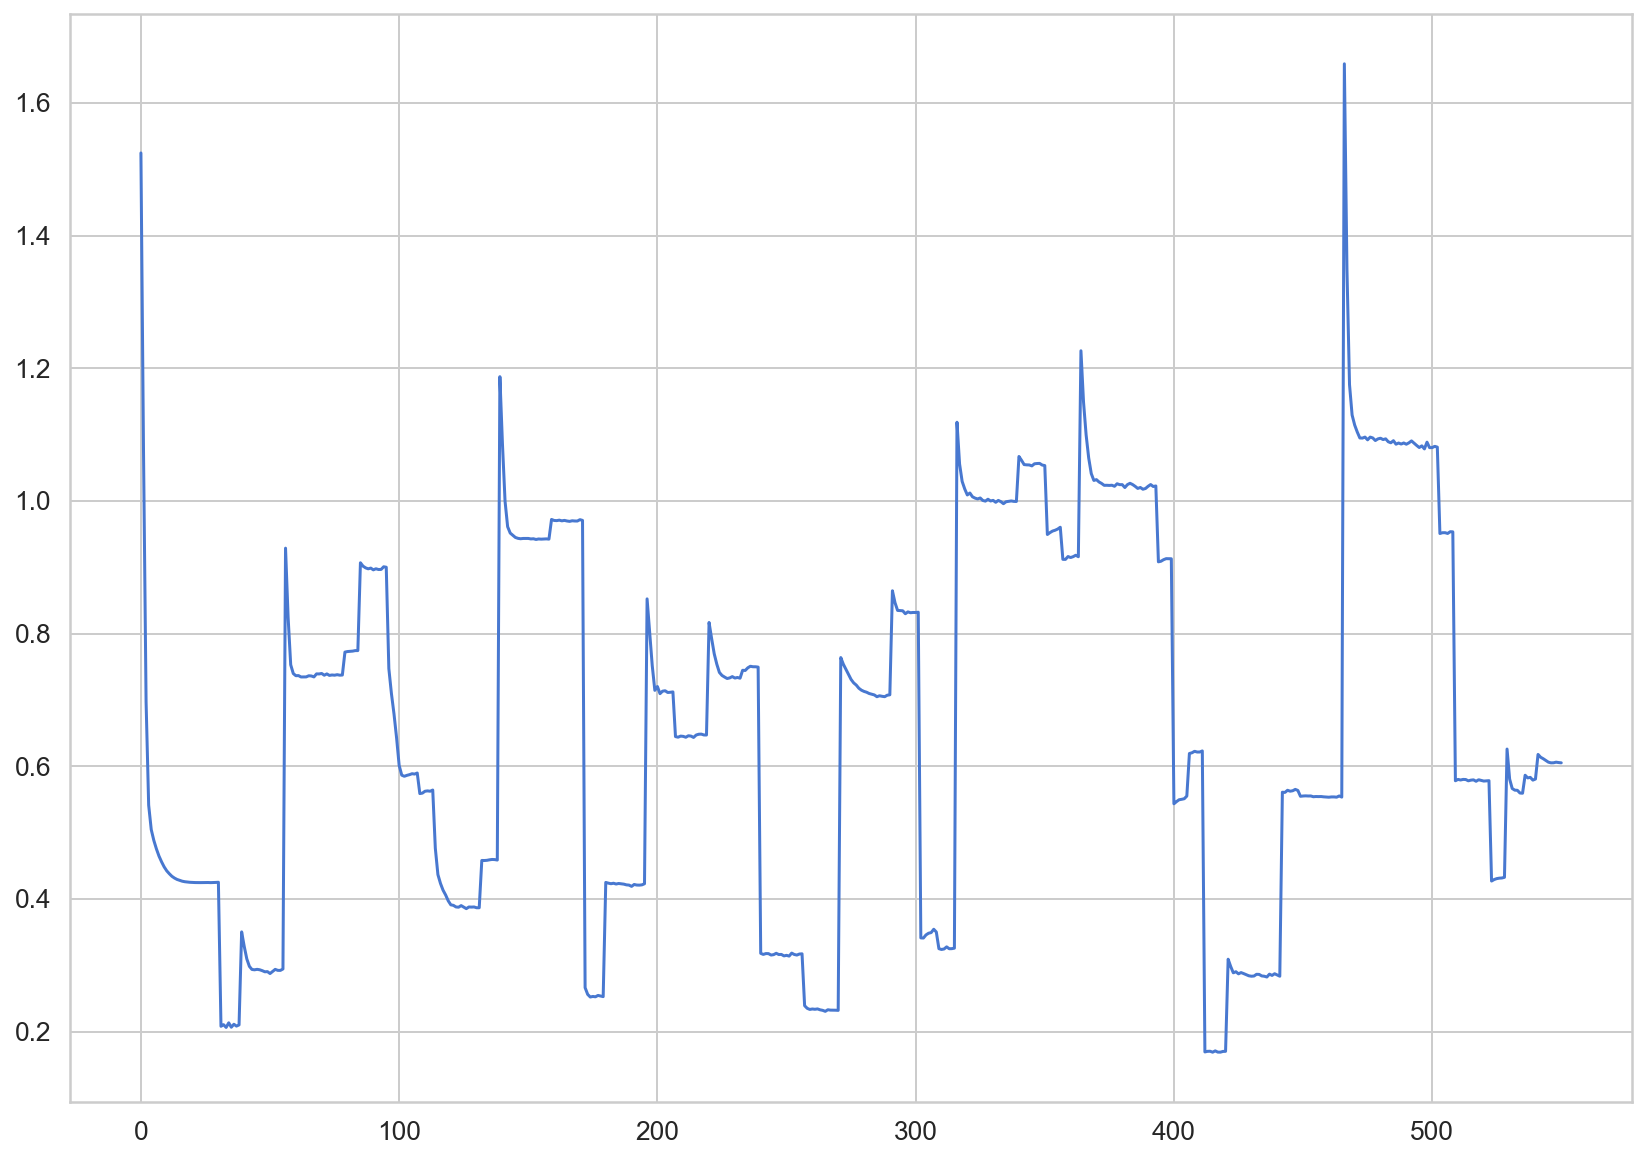

In [13]:
plt.plot(history_val_loss)

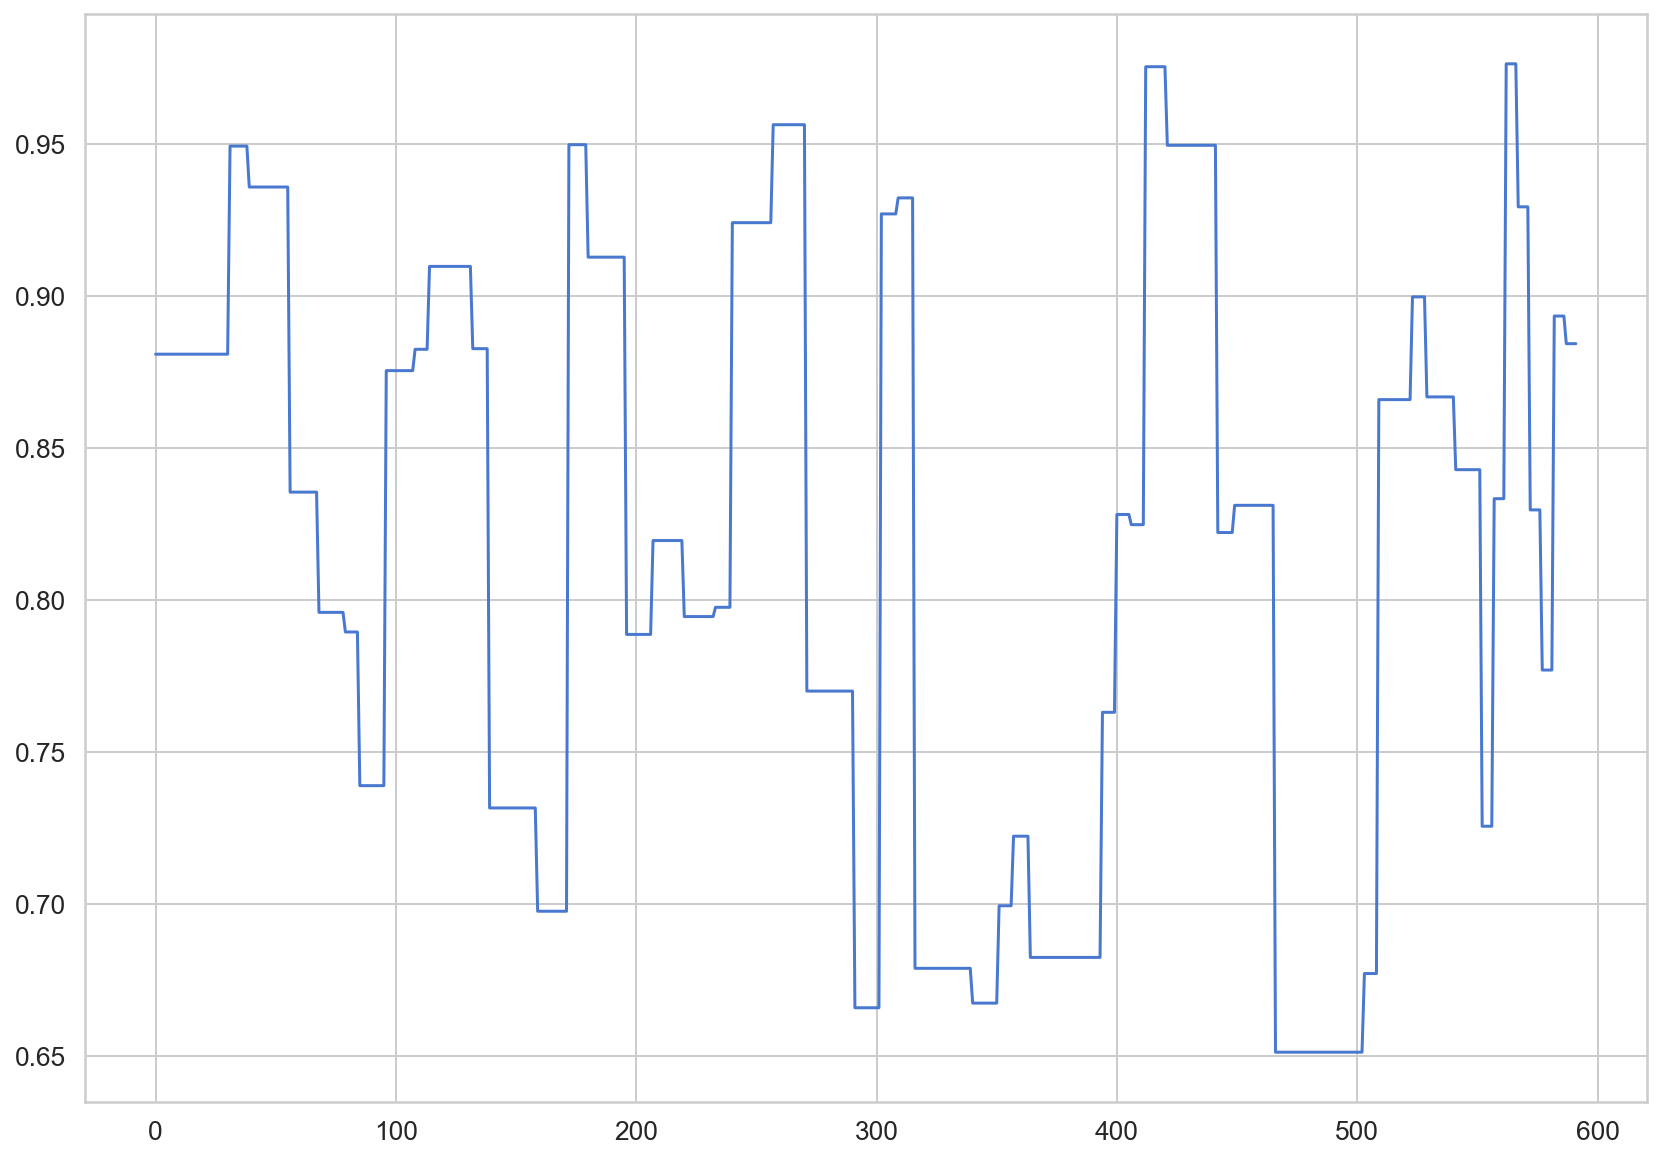

In [14]:
plt.plot(history_val_accuracy)

In [15]:
print(eval_list)

[0.8756476640701294, 0.9483066201210022, 0.9547169804573059, 0.82280433177948, 0.7781201601028442, 0.7836257219314575, 0.7455196976661682, 0.8855218887329102, 0.8641975522041321, 0.8907956480979919, 0.8843749761581421, 0.695898175239563, 0.7154929637908936, 0.9389736652374268, 0.9073107242584229, 0.7769784331321716, 0.8175675868988037, 0.7964912056922913, 0.7819277048110962, 0.920634925365448, 0.9575597047805786, 0.7452574372291565, 0.675405740737915, 0.9255172610282898, 0.9143920540809631, 0.6715789437294006, 0.6614173054695129, 0.6690821051597595, 0.7233368754386902, 0.6925714015960693, 0.7634660601615906, 0.8508892059326172, 0.8233034610748291, 0.9687943458557129, 0.9468390941619873, 0.7923497557640076, 0.8105849623680115, 0.6821885704994202, 0.6763678789138794, 0.8642659187316895, 0.88289475440979, 0.8559218645095825, 0.847046434879303, 0.6840730905532837, 0.8119891285896301, 0.9577804803848267, 0.9316703081130981, 0.8541114330291748, 0.7937853336334229, 0.8622754216194153, 0.90794

In [19]:
print(sum(eval_list)/len(eval_list))

0.8233248521299923


In [17]:
from sklearn.metrics import f1_score

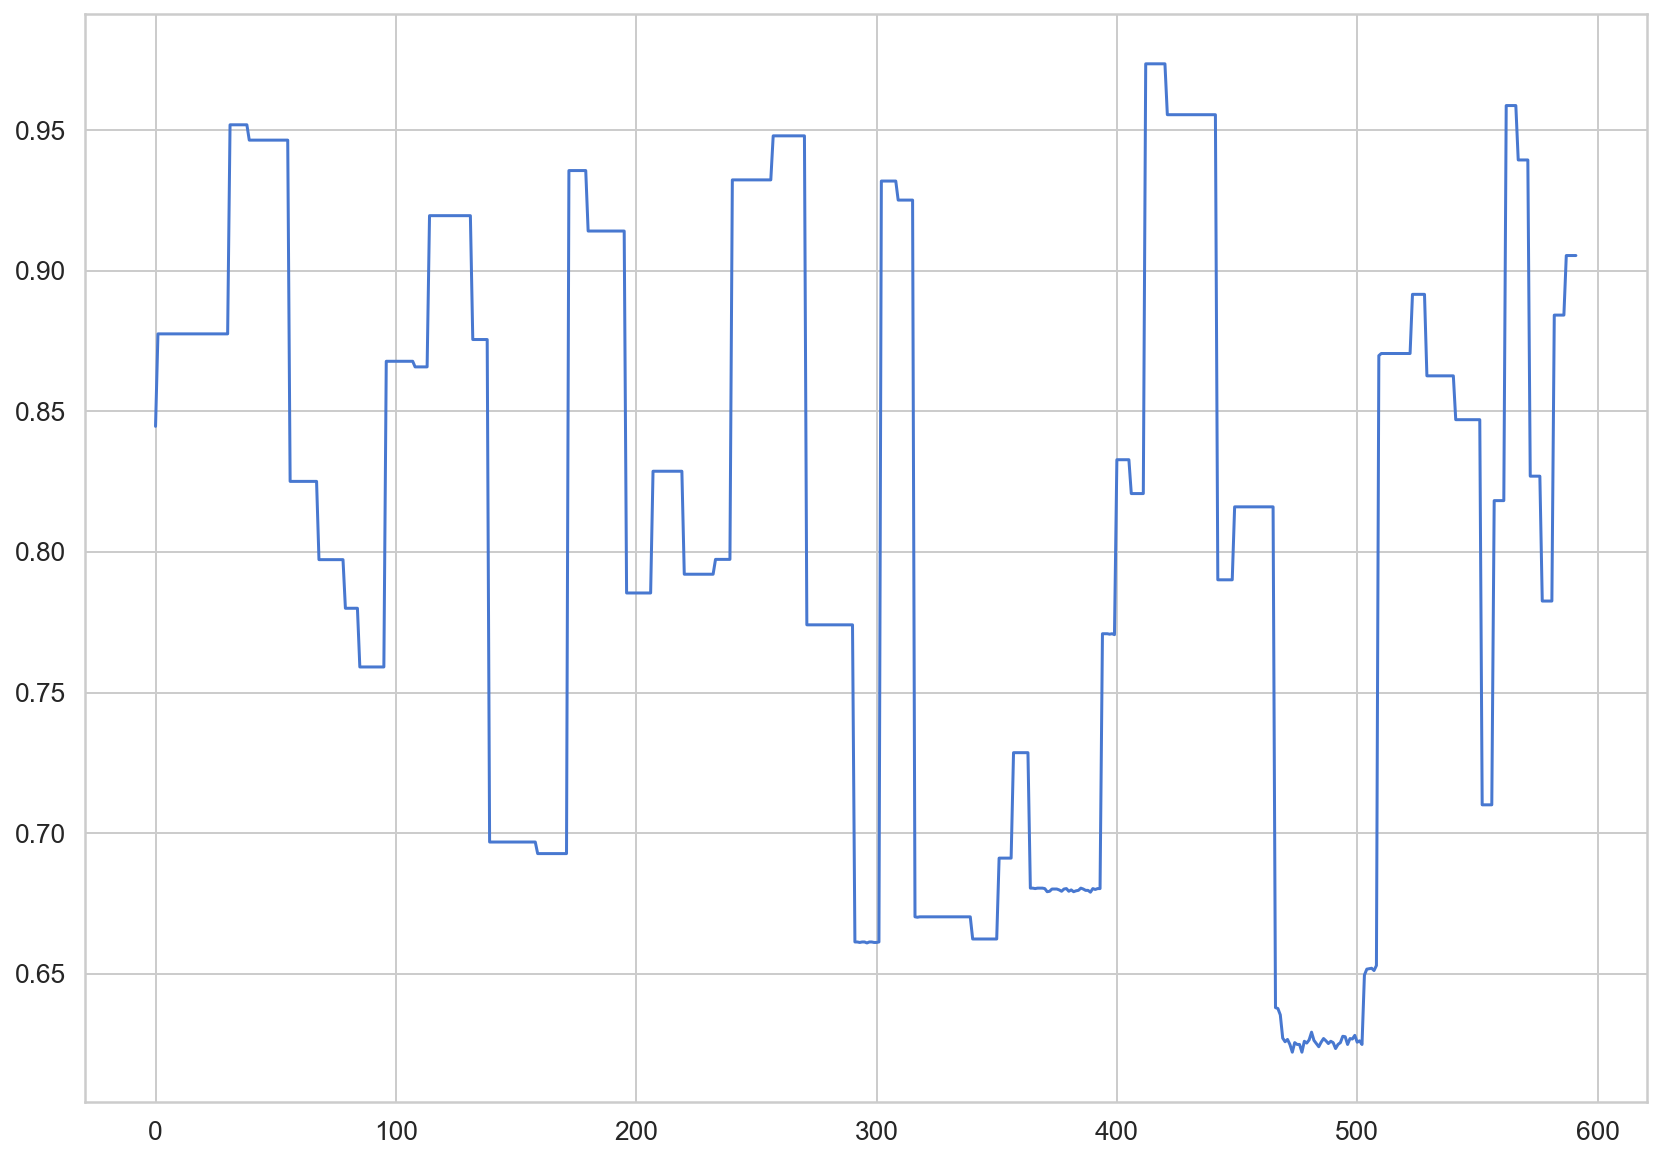

In [18]:
plt.plot(history_accuracy)